In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla, Reverse_kernel, Accept_func
from models import Gen_network, Inf_network, Inf_network_simple, Gen_network_simple
from target import NN_bernoulli, GMM_target, NN_Gaussian
from utils import plot_digit_samples, get_samples
from args import get_args

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

args.data = "mnist"
args.z_dim = 64
args.data_distrib = GMM_target(args, args.device)

In [5]:


if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.learnable_reverse:
    reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.learnable_accept:
    accept_func = Accept_func(kwargs=args).to(args.device)
    accept_params = accept_func.parameters()
else:
    accept_params = list([])
    
if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)

if args.separate_params:
    params_decoder = list(target.parameters())
    params_inference = list(encoder.parameters()) + list(transitions.parameters()) + list(reverse_params) +list(accept_params)
    optimizer_inference = torch.optim.Adam(params=params_inference, lr=args.learning_rate_inference)
    optimizer = torch.optim.Adam(params=params_decoder, lr=args.learning_rate)
else:
    params = list(encoder.parameters()) + list(target.parameters()) + list(transitions.parameters()) + list(reverse_params)+list(accept_params)
    optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
    
optimizer_vanilla = torch.optim.Adam(params=list(encoder.parameters()) + list(target.parameters()), lr= args.learning_rate_vanilla)



In [6]:
if args.vanilla_vae_epoches > 0:
    batch_size = args.train_batch_size
    args.train_batch_size = 100 # just for Vanilla VAE training
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

In [8]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None, h=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), h=h.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
        
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new.sum(1))
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo 

In [9]:
def validate_vae(args, encoder, target, transitions, dataset):
    elbo_list = []
    for batch_num, batch_val in enumerate(dataset.next_val_batch()):
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        mu, sigma, h = encoder(batch_val)
        
        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u
        
        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]
        p = p_old
        
        for k in range(args.K):
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_val,
                                                    p_old=p, k=cond_vectors[k], target_distr=target, accept_func= accept_func, h=h)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_val,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target, accept_func= accept_func, h=h) # sample a_i -- directions
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        
        elbo_current, _ = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_val, sum_log_alpha=sum_log_alpha,
                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions, h=h)
        
        elbo_list.append(elbo_current.cpu().detach().numpy())
    mean_val_elbo = np.mean(elbo_list)
    return mean_val_elbo

  0%|          | 0/1000 [00:00<?, ?it/s]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 401/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 501/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
Current epoch: 1 	 Current ELBO train: -323.3589782714844
Best elbo validation -121.44772
Current elbo validation -121.44772
Saved samples to ./pics/mnist_epoch_0_K_1_N_1_amortize_False.png


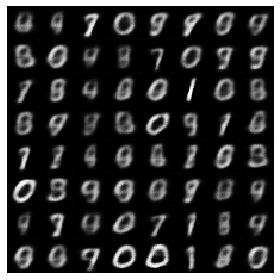

  0%|          | 1/1000 [00:31<8:50:14, 31.85s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.6999999843537807 and for +1: 0.29999999329447746
On batch number 101/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 201/590 and on k = 1 we have for  0: 0.7399999834597111 and for +1: 0.25999999418854713
On batch number 301/590 and on k = 1 we have for  0: 0.6799999848008156 and for +1: 0.3199999928474426
On batch number 401/590 and on k = 1 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 501/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
Current epoch: 2 	 Current ELBO train: -298.79913330078125
Best elbo validation -82.82914
Current elbo validation -82.82914
Saved samples to ./pics/mnist_epoch_1_K_1_N_1_amortize_False.png


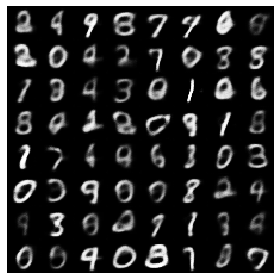

  0%|          | 2/1000 [01:03<8:50:20, 31.88s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.7499999832361937 and for +1: 0.24999999441206455
On batch number 101/590 and on k = 1 we have for  0: 0.7599999830126762 and for +1: 0.23999999463558197
On batch number 201/590 and on k = 1 we have for  0: 0.7799999825656414 and for +1: 0.2199999950826168
On batch number 301/590 and on k = 1 we have for  0: 0.6499999854713678 and for +1: 0.3499999921768904
On batch number 401/590 and on k = 1 we have for  0: 0.7599999830126762 and for +1: 0.23999999463558197
On batch number 501/590 and on k = 1 we have for  0: 0.789999982342124 and for +1: 0.20999999530613422
Current epoch: 3 	 Current ELBO train: -281.58050537109375
Best elbo validation -61.98153
Current elbo validation -61.98153
Saved samples to ./pics/mnist_epoch_2_K_1_N_1_amortize_False.png


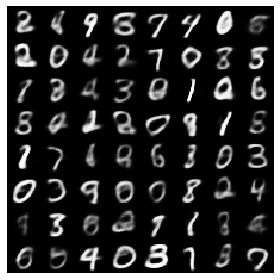

  0%|          | 3/1000 [01:35<8:49:55, 31.89s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.7699999827891588 and for +1: 0.2299999948590994
On batch number 101/590 and on k = 1 we have for  0: 0.6599999852478504 and for +1: 0.3399999924004078
On batch number 201/590 and on k = 1 we have for  0: 0.6899999845772982 and for +1: 0.30999999307096004
On batch number 301/590 and on k = 1 we have for  0: 0.669999985024333 and for +1: 0.3299999926239252
On batch number 401/590 and on k = 1 we have for  0: 0.7299999836832285 and for +1: 0.2699999939650297
On batch number 501/590 and on k = 1 we have for  0: 0.7199999839067459 and for +1: 0.2799999937415123
Current epoch: 4 	 Current ELBO train: -274.5140075683594
Best elbo validation -60.74717
Current elbo validation -60.74717
Saved samples to ./pics/mnist_epoch_3_K_1_N_1_amortize_False.png


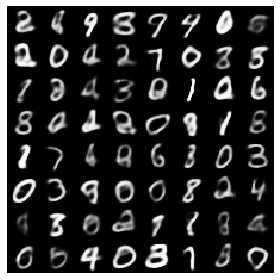

  0%|          | 4/1000 [02:07<8:49:41, 31.91s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.6799999848008156 and for +1: 0.3199999928474426
On batch number 101/590 and on k = 1 we have for  0: 0.7199999839067459 and for +1: 0.2799999937415123
On batch number 201/590 and on k = 1 we have for  0: 0.669999985024333 and for +1: 0.3299999926239252
On batch number 301/590 and on k = 1 we have for  0: 0.669999985024333 and for +1: 0.3299999926239252
On batch number 401/590 and on k = 1 we have for  0: 0.7199999839067459 and for +1: 0.2799999937415123
On batch number 501/590 and on k = 1 we have for  0: 0.6799999848008156 and for +1: 0.3199999928474426
Current epoch: 5 	 Current ELBO train: -274.73944091796875
Best elbo validation -56.91092
Current elbo validation -56.91092
Saved samples to ./pics/mnist_epoch_4_K_1_N_1_amortize_False.png


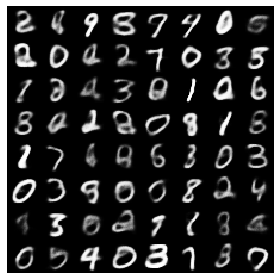

  0%|          | 5/1000 [02:39<8:50:05, 31.97s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.7599999830126762 and for +1: 0.23999999463558197
On batch number 101/590 and on k = 1 we have for  0: 0.7199999839067459 and for +1: 0.2799999937415123
On batch number 201/590 and on k = 1 we have for  0: 0.6999999843537807 and for +1: 0.29999999329447746
On batch number 301/590 and on k = 1 we have for  0: 0.6899999845772982 and for +1: 0.30999999307096004
On batch number 401/590 and on k = 1 we have for  0: 0.6799999848008156 and for +1: 0.3199999928474426
On batch number 501/590 and on k = 1 we have for  0: 0.669999985024333 and for +1: 0.3299999926239252
Current epoch: 6 	 Current ELBO train: -271.4816589355469
Best elbo validation -50.698772
Current elbo validation -50.698772
Saved samples to ./pics/mnist_epoch_5_K_1_N_1_amortize_False.png


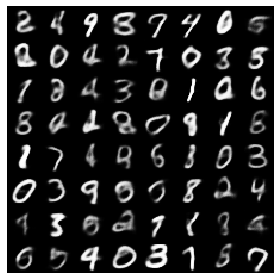

  1%|          | 6/1000 [03:11<8:50:28, 32.02s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.8099999818950891 and for +1: 0.18999999575316906
On batch number 101/590 and on k = 1 we have for  0: 0.8899999801069498 and for +1: 0.1099999975413084
On batch number 201/590 and on k = 1 we have for  0: 0.9699999783188105 and for +1: 0.029999999329447746
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 7 	 Current ELBO train: -269.1103515625
Best elbo validation -49.834183
Current elbo validation -49.834183
Saved samples to ./pics/mnist_epoch_6_K_1_N_1_amortize_False.png


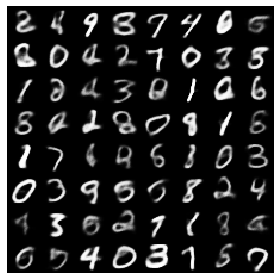

  1%|          | 7/1000 [03:44<8:50:34, 32.06s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
Current epoch: 8 	 Current ELBO train: -269.40362548828125
Best elbo validation -49.834183
Current elbo validation -52.763157
Saved samples to ./pics/mnist_epoch_7_K_1_N_1_amortize_False.png


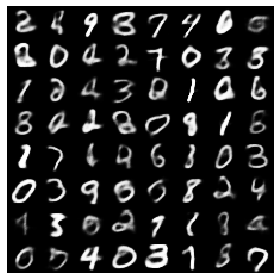

  1%|          | 8/1000 [04:16<8:50:24, 32.08s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 9 	 Current ELBO train: -276.92431640625
Best elbo validation -46.71084
Current elbo validation -46.71084
Saved samples to ./pics/mnist_epoch_8_K_1_N_1_amortize_False.png


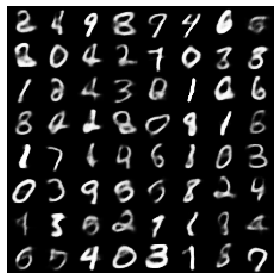

  1%|          | 9/1000 [04:48<8:51:16, 32.17s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 10 	 Current ELBO train: -272.4768981933594
Best elbo validation -46.32313
Current elbo validation -46.32313
Saved samples to ./pics/mnist_epoch_9_K_1_N_1_amortize_False.png


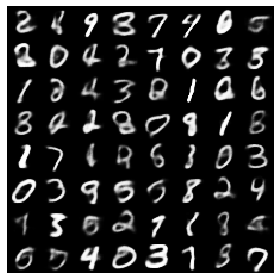

  1%|          | 10/1000 [05:20<8:51:30, 32.21s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 11 	 Current ELBO train: -269.98455810546875
Best elbo validation -46.32313
Current elbo validation -47.68428
Saved samples to ./pics/mnist_epoch_10_K_1_N_1_amortize_False.png


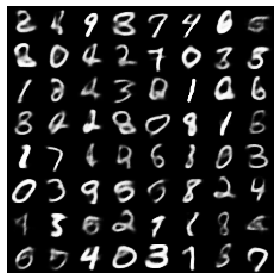

  1%|          | 11/1000 [05:53<8:50:41, 32.20s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 12 	 Current ELBO train: -267.9323425292969
Best elbo validation -44.82029
Current elbo validation -44.82029
Saved samples to ./pics/mnist_epoch_11_K_1_N_1_amortize_False.png


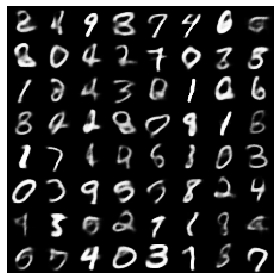

  1%|          | 12/1000 [06:25<8:49:59, 32.19s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 13 	 Current ELBO train: -262.4473876953125
Best elbo validation -43.61788
Current elbo validation -43.61788
Saved samples to ./pics/mnist_epoch_12_K_1_N_1_amortize_False.png


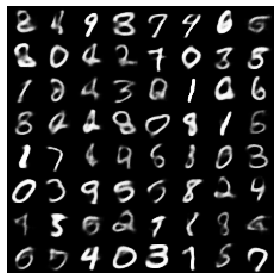

  1%|▏         | 13/1000 [06:57<8:49:12, 32.17s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.7699999827891588 and for +1: 0.2299999948590994
On batch number 301/590 and on k = 1 we have for  0: 0.8699999805539846 and for +1: 0.12999999709427357
On batch number 401/590 and on k = 1 we have for  0: 0.8699999805539846 and for +1: 0.12999999709427357
On batch number 501/590 and on k = 1 we have for  0: 0.7599999830126762 and for +1: 0.23999999463558197
Current epoch: 14 	 Current ELBO train: -265.81793212890625
Best elbo validation -43.61788
Current elbo validation -45.512085
Saved samples to ./pics/mnist_epoch_13_K_1_N_1_amortize_False.png


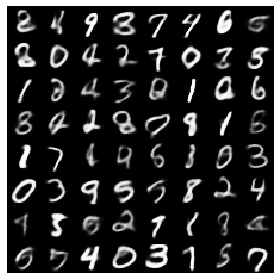

  1%|▏         | 14/1000 [07:29<8:48:31, 32.16s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.7999999821186066 and for +1: 0.19999999552965164
On batch number 101/590 and on k = 1 we have for  0: 0.8699999805539846 and for +1: 0.12999999709427357
On batch number 201/590 and on k = 1 we have for  0: 0.7199999839067459 and for +1: 0.2799999937415123
On batch number 301/590 and on k = 1 we have for  0: 0.8399999812245369 and for +1: 0.1599999964237213
On batch number 401/590 and on k = 1 we have for  0: 0.7999999821186066 and for +1: 0.19999999552965164
On batch number 501/590 and on k = 1 we have for  0: 0.8699999805539846 and for +1: 0.12999999709427357
Current epoch: 15 	 Current ELBO train: -270.8009033203125
Best elbo validation -43.61788
Current elbo validation -45.679005
Saved samples to ./pics/mnist_epoch_14_K_1_N_1_amortize_False.png


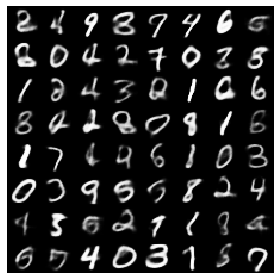

  2%|▏         | 15/1000 [08:01<8:47:48, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 16 	 Current ELBO train: -270.9577331542969
Best elbo validation -41.98009
Current elbo validation -41.98009
Saved samples to ./pics/mnist_epoch_15_K_1_N_1_amortize_False.png


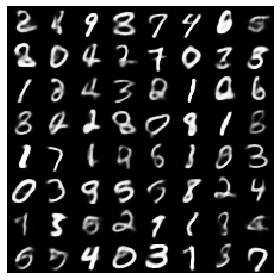

  2%|▏         | 16/1000 [08:33<8:47:12, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 17 	 Current ELBO train: -266.973876953125
Best elbo validation -41.98009
Current elbo validation -45.764923
Saved samples to ./pics/mnist_epoch_16_K_1_N_1_amortize_False.png


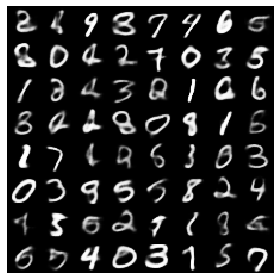

  2%|▏         | 17/1000 [09:05<8:46:29, 32.14s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 18 	 Current ELBO train: -267.78106689453125
Best elbo validation -41.98009
Current elbo validation -44.352066
Saved samples to ./pics/mnist_epoch_17_K_1_N_1_amortize_False.png


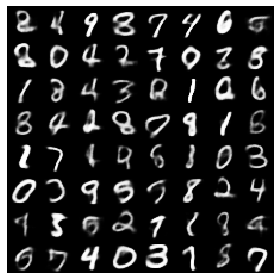

  2%|▏         | 18/1000 [09:37<8:45:49, 32.13s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 19 	 Current ELBO train: -266.50103759765625
Best elbo validation -41.166706
Current elbo validation -41.166706
Saved samples to ./pics/mnist_epoch_18_K_1_N_1_amortize_False.png


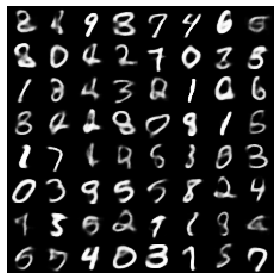

  2%|▏         | 19/1000 [10:10<8:45:56, 32.17s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 20 	 Current ELBO train: -262.14892578125
Best elbo validation -41.077106
Current elbo validation -41.077106
Saved samples to ./pics/mnist_epoch_19_K_1_N_1_amortize_False.png


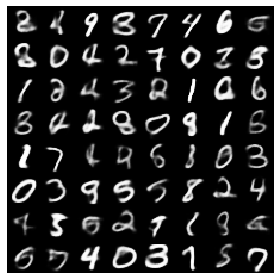

  2%|▏         | 20/1000 [10:42<8:45:51, 32.20s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 21 	 Current ELBO train: -268.6726379394531
Best elbo validation -41.077106
Current elbo validation -42.435295
Saved samples to ./pics/mnist_epoch_20_K_1_N_1_amortize_False.png


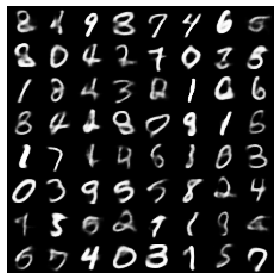

  2%|▏         | 21/1000 [11:14<8:45:06, 32.18s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 22 	 Current ELBO train: -261.3271179199219
Best elbo validation -41.028934
Current elbo validation -41.028934
Saved samples to ./pics/mnist_epoch_21_K_1_N_1_amortize_False.png


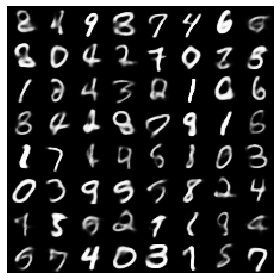

  2%|▏         | 22/1000 [11:46<8:44:28, 32.18s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 23 	 Current ELBO train: -261.14501953125
Best elbo validation -41.028934
Current elbo validation -41.30097
Saved samples to ./pics/mnist_epoch_22_K_1_N_1_amortize_False.png


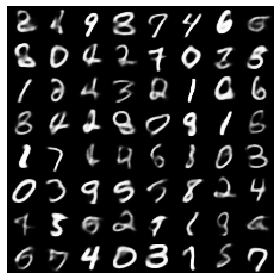

  2%|▏         | 23/1000 [12:18<8:43:45, 32.17s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 24 	 Current ELBO train: -264.9466247558594
Best elbo validation -40.658836
Current elbo validation -40.658836
Saved samples to ./pics/mnist_epoch_23_K_1_N_1_amortize_False.png


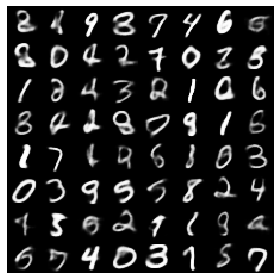

  2%|▏         | 24/1000 [12:51<8:43:15, 32.17s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 25 	 Current ELBO train: -260.8406066894531
Best elbo validation -40.658836
Current elbo validation -40.954006
Saved samples to ./pics/mnist_epoch_24_K_1_N_1_amortize_False.png


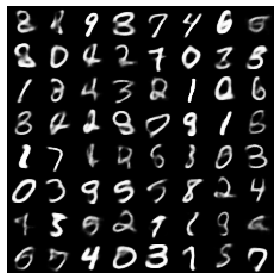

  2%|▎         | 25/1000 [13:23<8:42:30, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 26 	 Current ELBO train: -262.4275817871094
Best elbo validation -40.658836
Current elbo validation -42.610455
Saved samples to ./pics/mnist_epoch_25_K_1_N_1_amortize_False.png


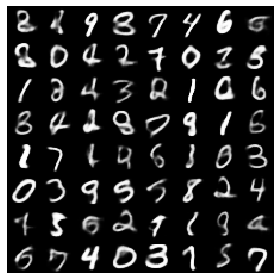

  3%|▎         | 26/1000 [13:55<8:41:57, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 27 	 Current ELBO train: -263.34423828125
Best elbo validation -39.21085
Current elbo validation -39.21085
Saved samples to ./pics/mnist_epoch_26_K_1_N_1_amortize_False.png


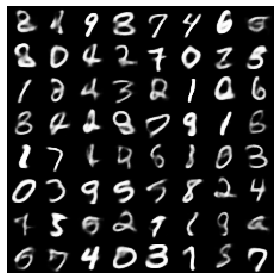

  3%|▎         | 27/1000 [14:27<8:41:21, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 28 	 Current ELBO train: -260.7791442871094
Best elbo validation -39.21085
Current elbo validation -41.42975
Saved samples to ./pics/mnist_epoch_27_K_1_N_1_amortize_False.png


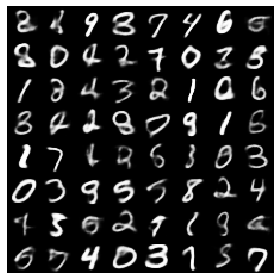

  3%|▎         | 28/1000 [14:59<8:40:47, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 29 	 Current ELBO train: -258.5994567871094
Best elbo validation -39.21085
Current elbo validation -41.15525
Saved samples to ./pics/mnist_epoch_28_K_1_N_1_amortize_False.png


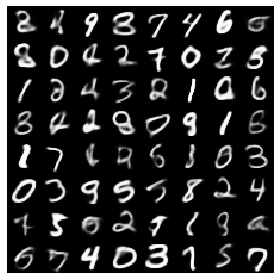

  3%|▎         | 29/1000 [15:32<8:41:18, 32.21s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 30 	 Current ELBO train: -258.78912353515625
Best elbo validation -39.21085
Current elbo validation -40.599983
Saved samples to ./pics/mnist_epoch_29_K_1_N_1_amortize_False.png


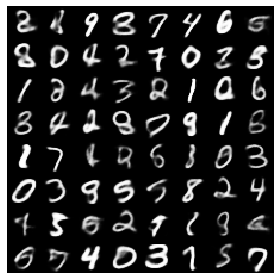

  3%|▎         | 30/1000 [16:04<8:41:08, 32.24s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 31 	 Current ELBO train: -262.6640930175781
Best elbo validation -39.21085
Current elbo validation -40.263557
Saved samples to ./pics/mnist_epoch_30_K_1_N_1_amortize_False.png


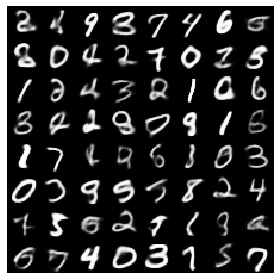

  3%|▎         | 31/1000 [16:36<8:40:01, 32.20s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 32 	 Current ELBO train: -255.2324981689453
Best elbo validation -39.21085
Current elbo validation -40.320095
Saved samples to ./pics/mnist_epoch_31_K_1_N_1_amortize_False.png


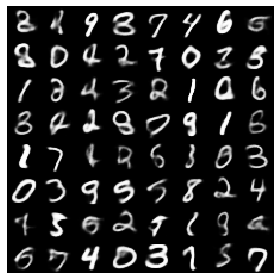

  3%|▎         | 32/1000 [17:08<8:39:05, 32.18s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 33 	 Current ELBO train: -261.80560302734375
Best elbo validation -39.21085
Current elbo validation -43.074726
Saved samples to ./pics/mnist_epoch_32_K_1_N_1_amortize_False.png


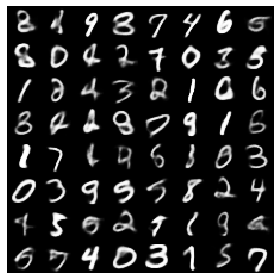

  3%|▎         | 33/1000 [17:40<8:38:27, 32.17s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 34 	 Current ELBO train: -264.8885498046875
Best elbo validation -39.21085
Current elbo validation -41.859478
Saved samples to ./pics/mnist_epoch_33_K_1_N_1_amortize_False.png


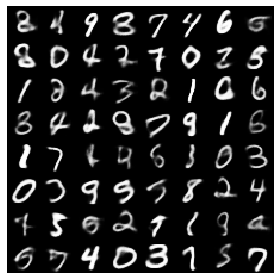

  3%|▎         | 34/1000 [18:12<8:37:40, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 35 	 Current ELBO train: -258.1531066894531
Best elbo validation -39.21085
Current elbo validation -40.60037
Saved samples to ./pics/mnist_epoch_34_K_1_N_1_amortize_False.png


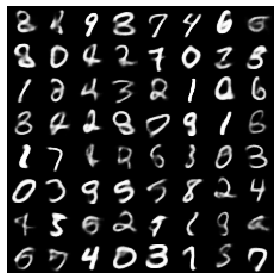

  4%|▎         | 35/1000 [18:44<8:37:00, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 36 	 Current ELBO train: -264.3992614746094
Best elbo validation -39.21085
Current elbo validation -41.07091
Saved samples to ./pics/mnist_epoch_35_K_1_N_1_amortize_False.png


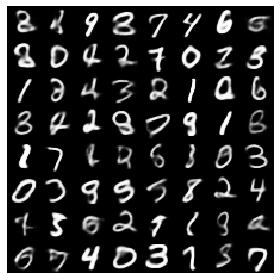

  4%|▎         | 36/1000 [19:17<8:36:24, 32.14s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 37 	 Current ELBO train: -257.53277587890625
Best elbo validation -39.21085
Current elbo validation -40.8036
Saved samples to ./pics/mnist_epoch_36_K_1_N_1_amortize_False.png


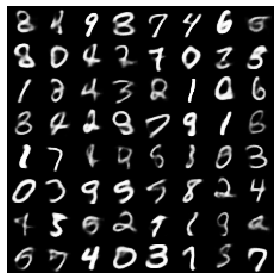

  4%|▎         | 37/1000 [19:49<8:36:04, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 38 	 Current ELBO train: -259.2120361328125
Best elbo validation -39.21085
Current elbo validation -42.67058
Saved samples to ./pics/mnist_epoch_37_K_1_N_1_amortize_False.png


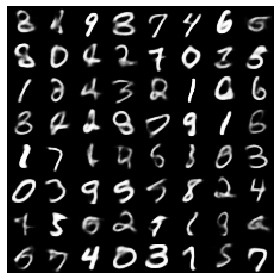

  4%|▍         | 38/1000 [20:21<8:35:33, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 39 	 Current ELBO train: -259.5243225097656
Best elbo validation -39.21085
Current elbo validation -39.962944
Saved samples to ./pics/mnist_epoch_38_K_1_N_1_amortize_False.png


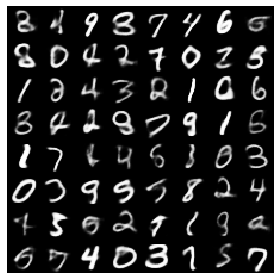

  4%|▍         | 39/1000 [20:53<8:35:39, 32.20s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 40 	 Current ELBO train: -266.4796142578125
Best elbo validation -39.21085
Current elbo validation -40.30863
Saved samples to ./pics/mnist_epoch_39_K_1_N_1_amortize_False.png


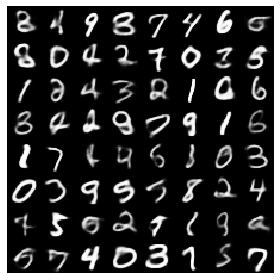

  4%|▍         | 40/1000 [21:26<8:35:39, 32.23s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 41 	 Current ELBO train: -257.22393798828125
Best elbo validation -39.21085
Current elbo validation -39.3607
Saved samples to ./pics/mnist_epoch_40_K_1_N_1_amortize_False.png


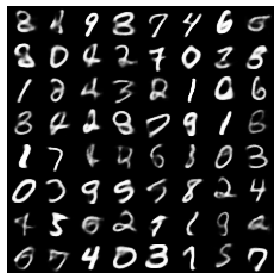

  4%|▍         | 41/1000 [21:58<8:34:38, 32.20s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 42 	 Current ELBO train: -254.7549591064453
Best elbo validation -39.21085
Current elbo validation -42.122616
Saved samples to ./pics/mnist_epoch_41_K_1_N_1_amortize_False.png


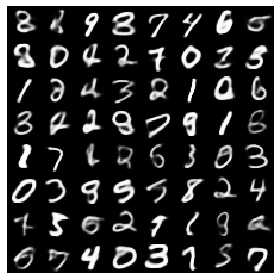

  4%|▍         | 42/1000 [22:30<8:33:44, 32.18s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 43 	 Current ELBO train: -256.2798767089844
Best elbo validation -39.21085
Current elbo validation -41.719585
Saved samples to ./pics/mnist_epoch_42_K_1_N_1_amortize_False.png


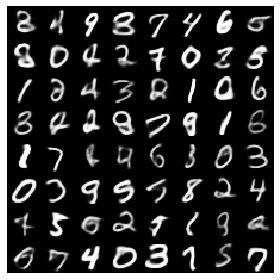

  4%|▍         | 43/1000 [23:02<8:33:01, 32.16s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 44 	 Current ELBO train: -258.7787780761719
Best elbo validation -38.520626
Current elbo validation -38.520626
Saved samples to ./pics/mnist_epoch_43_K_1_N_1_amortize_False.png


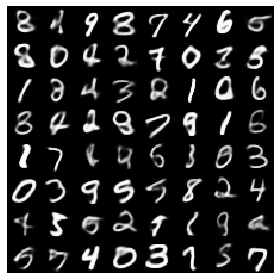

  4%|▍         | 44/1000 [23:34<8:32:25, 32.16s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 45 	 Current ELBO train: -256.5140075683594
Best elbo validation -38.520626
Current elbo validation -39.470272
Saved samples to ./pics/mnist_epoch_44_K_1_N_1_amortize_False.png


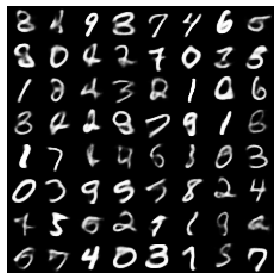

  4%|▍         | 45/1000 [24:06<8:31:44, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 46 	 Current ELBO train: -256.92791748046875
Best elbo validation -38.520626
Current elbo validation -39.573524
Saved samples to ./pics/mnist_epoch_45_K_1_N_1_amortize_False.png


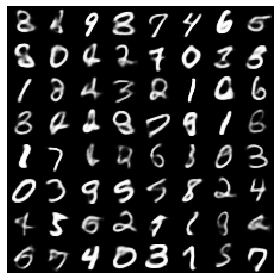

  5%|▍         | 46/1000 [24:38<8:31:34, 32.17s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 47 	 Current ELBO train: -256.66192626953125
Best elbo validation -38.520626
Current elbo validation -39.767223
Saved samples to ./pics/mnist_epoch_46_K_1_N_1_amortize_False.png


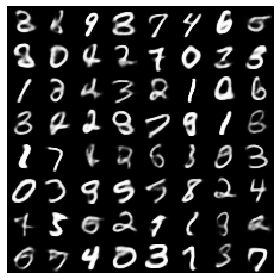

  5%|▍         | 47/1000 [25:11<8:30:48, 32.16s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 48 	 Current ELBO train: -256.7849426269531
Best elbo validation -38.469616
Current elbo validation -38.469616
Saved samples to ./pics/mnist_epoch_47_K_1_N_1_amortize_False.png


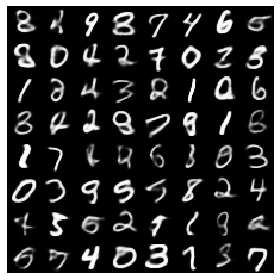

  5%|▍         | 48/1000 [25:43<8:30:10, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 49 	 Current ELBO train: -254.52256774902344
Best elbo validation -36.734936
Current elbo validation -36.734936
Saved samples to ./pics/mnist_epoch_48_K_1_N_1_amortize_False.png


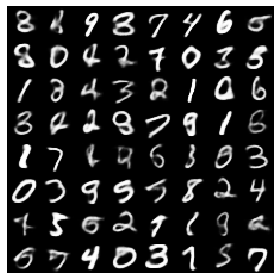

  5%|▍         | 49/1000 [26:15<8:30:19, 32.20s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 50 	 Current ELBO train: -264.7078552246094
Best elbo validation -36.734936
Current elbo validation -39.39045
Saved samples to ./pics/mnist_epoch_49_K_1_N_1_amortize_False.png


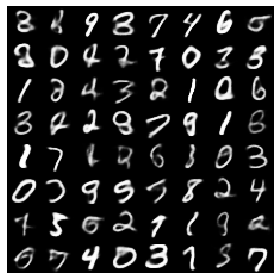

  5%|▌         | 50/1000 [26:47<8:30:03, 32.21s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 51 	 Current ELBO train: -259.49969482421875
Best elbo validation -36.734936
Current elbo validation -39.20784
Saved samples to ./pics/mnist_epoch_50_K_1_N_1_amortize_False.png


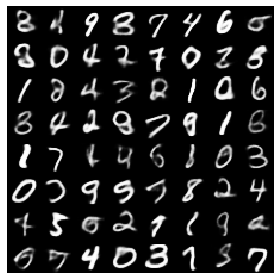

  5%|▌         | 51/1000 [27:19<8:29:11, 32.19s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 52 	 Current ELBO train: -258.149658203125
Best elbo validation -36.734936
Current elbo validation -38.131958
Saved samples to ./pics/mnist_epoch_51_K_1_N_1_amortize_False.png


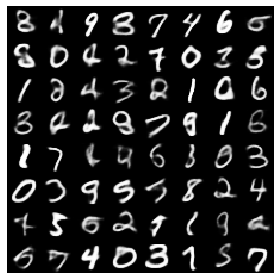

  5%|▌         | 52/1000 [27:52<8:28:32, 32.19s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 53 	 Current ELBO train: -256.9244384765625
Best elbo validation -36.734936
Current elbo validation -39.550556
Saved samples to ./pics/mnist_epoch_52_K_1_N_1_amortize_False.png


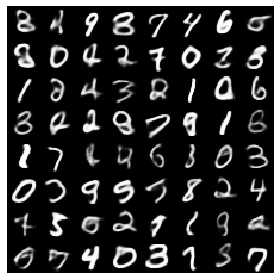

  5%|▌         | 53/1000 [28:24<8:27:56, 32.18s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 54 	 Current ELBO train: -259.64984130859375
Best elbo validation -36.734936
Current elbo validation -38.423126
Saved samples to ./pics/mnist_epoch_53_K_1_N_1_amortize_False.png


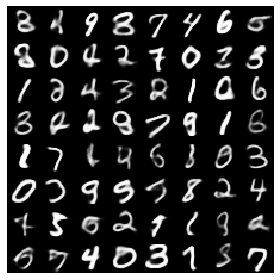

  5%|▌         | 54/1000 [28:56<8:27:04, 32.16s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
On batch number 501/590 and on k = 1 we have for  0: 0.9299999792128801 and for +1: 0.06999999843537807
Current epoch: 55 	 Current ELBO train: -256.9203186035156
Best elbo validation -36.734936
Current elbo validation -39.454273
Saved samples to ./pics/mnist_epoch_54_K_1_N_1_amortize_False.png


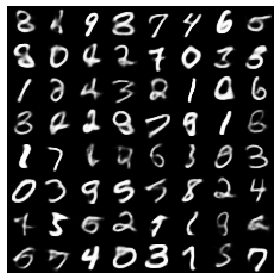

  6%|▌         | 55/1000 [29:28<8:26:21, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 101/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 201/590 and on k = 1 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
On batch number 501/590 and on k = 1 we have for  0: 0.9599999785423279 and for +1: 0.03999999910593033
Current epoch: 56 	 Current ELBO train: -255.5898895263672
Best elbo validation -36.734936
Current elbo validation -38.78635
Saved samples to ./pics/mnist_epoch_55_K_1_N_1_amortize_False.png


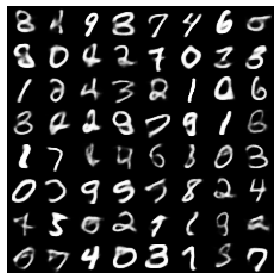

  6%|▌         | 56/1000 [30:00<8:25:40, 32.14s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9599999785423279 and for +1: 0.03999999910593033
On batch number 201/590 and on k = 1 we have for  0: 0.9499999787658453 and for +1: 0.04999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 501/590 and on k = 1 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
Current epoch: 57 	 Current ELBO train: -256.2921142578125
Best elbo validation -36.734936
Current elbo validation -39.722546
Saved samples to ./pics/mnist_epoch_56_K_1_N_1_amortize_False.png


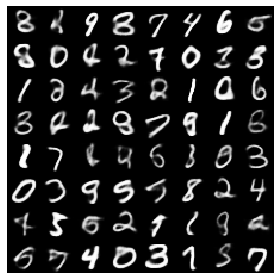

  6%|▌         | 57/1000 [30:32<8:25:14, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 58 	 Current ELBO train: -255.70159912109375
Best elbo validation -36.734936
Current elbo validation -39.169647
Saved samples to ./pics/mnist_epoch_57_K_1_N_1_amortize_False.png


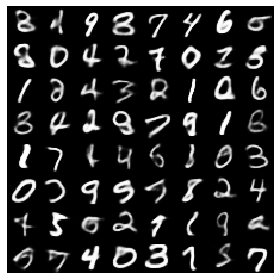

  6%|▌         | 58/1000 [31:04<8:25:00, 32.17s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 59 	 Current ELBO train: -253.08135986328125
Best elbo validation -36.734936
Current elbo validation -38.44739
Saved samples to ./pics/mnist_epoch_58_K_1_N_1_amortize_False.png


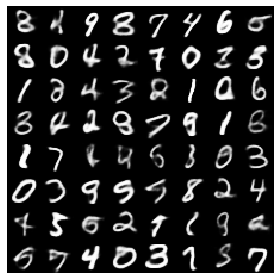

  6%|▌         | 59/1000 [31:37<8:24:53, 32.19s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 60 	 Current ELBO train: -256.240478515625
Best elbo validation -36.734936
Current elbo validation -37.18905
Saved samples to ./pics/mnist_epoch_59_K_1_N_1_amortize_False.png


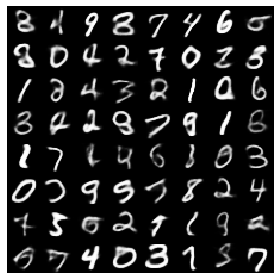

  6%|▌         | 60/1000 [32:09<8:24:39, 32.21s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 301/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 61 	 Current ELBO train: -257.9358825683594
Best elbo validation -36.734936
Current elbo validation -38.014484
Saved samples to ./pics/mnist_epoch_60_K_1_N_1_amortize_False.png


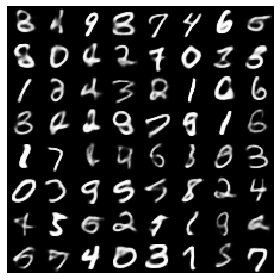

  6%|▌         | 61/1000 [32:41<8:23:45, 32.19s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
Current epoch: 62 	 Current ELBO train: -263.42138671875
Best elbo validation -36.734936
Current elbo validation -36.747265
Saved samples to ./pics/mnist_epoch_61_K_1_N_1_amortize_False.png


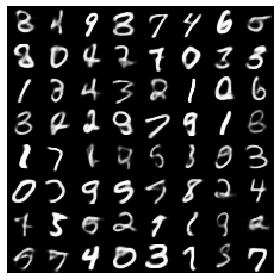

  6%|▌         | 62/1000 [33:13<8:22:52, 32.17s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
Current epoch: 63 	 Current ELBO train: -259.6015625
Best elbo validation -36.734936
Current elbo validation -39.056175
Saved samples to ./pics/mnist_epoch_62_K_1_N_1_amortize_False.png


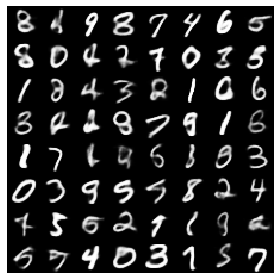

  6%|▋         | 63/1000 [33:45<8:22:13, 32.16s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.8899999801069498 and for +1: 0.1099999975413084
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9299999792128801 and for +1: 0.06999999843537807
On batch number 301/590 and on k = 1 we have for  0: 0.909999979659915 and for +1: 0.08999999798834324
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.7099999841302633 and for +1: 0.2899999935179949
Current epoch: 64 	 Current ELBO train: -263.54876708984375
Best elbo validation -36.734936
Current elbo validation -39.949837
Saved samples to ./pics/mnist_epoch_63_K_1_N_1_amortize_False.png


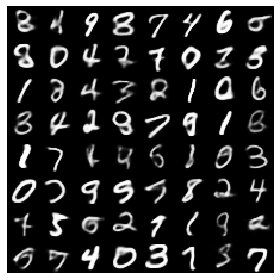

  6%|▋         | 64/1000 [34:18<8:21:38, 32.16s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.7999999821186066 and for +1: 0.19999999552965164
On batch number 101/590 and on k = 1 we have for  0: 0.9199999794363976 and for +1: 0.07999999821186066
On batch number 201/590 and on k = 1 we have for  0: 0.9299999792128801 and for +1: 0.06999999843537807
On batch number 301/590 and on k = 1 we have for  0: 0.9599999785423279 and for +1: 0.03999999910593033
On batch number 401/590 and on k = 1 we have for  0: 0.909999979659915 and for +1: 0.08999999798834324
On batch number 501/590 and on k = 1 we have for  0: 0.7299999836832285 and for +1: 0.2699999939650297
Current epoch: 65 	 Current ELBO train: -254.1553192138672
Best elbo validation -36.734936
Current elbo validation -38.013294
Saved samples to ./pics/mnist_epoch_64_K_1_N_1_amortize_False.png


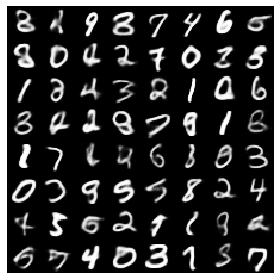

  6%|▋         | 65/1000 [34:50<8:20:56, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.7799999825656414 and for +1: 0.2199999950826168
On batch number 101/590 and on k = 1 we have for  0: 0.9199999794363976 and for +1: 0.07999999821186066
On batch number 201/590 and on k = 1 we have for  0: 0.9399999789893627 and for +1: 0.05999999865889549
On batch number 301/590 and on k = 1 we have for  0: 0.8799999803304672 and for +1: 0.11999999731779099
On batch number 401/590 and on k = 1 we have for  0: 0.8899999801069498 and for +1: 0.1099999975413084
On batch number 501/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
Current epoch: 66 	 Current ELBO train: -251.6277618408203
Best elbo validation -36.734936
Current elbo validation -38.264194
Saved samples to ./pics/mnist_epoch_65_K_1_N_1_amortize_False.png


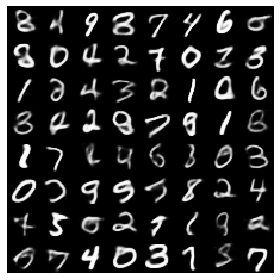

  7%|▋         | 66/1000 [35:22<8:20:26, 32.15s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9399999789893627 and for +1: 0.05999999865889549
On batch number 101/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 201/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 67 	 Current ELBO train: -254.98455810546875
Best elbo validation -36.734936
Current elbo validation -37.486954
Saved samples to ./pics/mnist_epoch_66_K_1_N_1_amortize_False.png


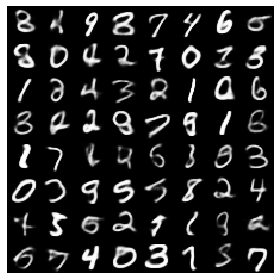

  7%|▋         | 67/1000 [35:54<8:19:48, 32.14s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9699999783188105 and for +1: 0.029999999329447746
Current epoch: 68 	 Current ELBO train: -253.14651489257812
Best elbo validation -36.734936
Current elbo validation -36.951744
Saved samples to ./pics/mnist_epoch_67_K_1_N_1_amortize_False.png


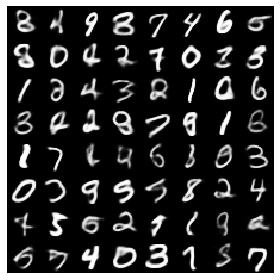

  7%|▋         | 68/1000 [36:26<8:19:08, 32.13s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 69 	 Current ELBO train: -257.6874084472656
Best elbo validation -36.385033
Current elbo validation -36.385033
Saved samples to ./pics/mnist_epoch_68_K_1_N_1_amortize_False.png


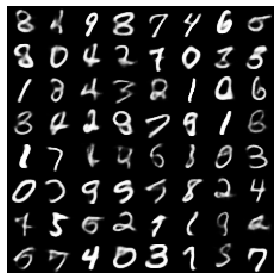

  7%|▋         | 69/1000 [36:58<8:19:24, 32.19s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 70 	 Current ELBO train: -255.97210693359375
Best elbo validation -36.385033
Current elbo validation -36.626064
Saved samples to ./pics/mnist_epoch_69_K_1_N_1_amortize_False.png


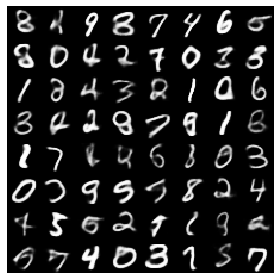

  7%|▋         | 70/1000 [37:31<8:19:14, 32.21s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9699999783188105 and for +1: 0.029999999329447746
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 71 	 Current ELBO train: -260.1319885253906
Best elbo validation -36.385033
Current elbo validation -40.80065
Saved samples to ./pics/mnist_epoch_70_K_1_N_1_amortize_False.png


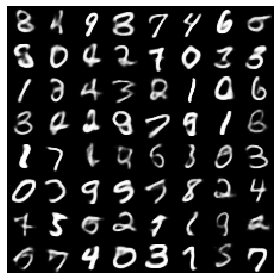

  7%|▋         | 71/1000 [38:03<8:18:26, 32.19s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 72 	 Current ELBO train: -263.85418701171875
Best elbo validation -36.385033
Current elbo validation -36.52087
Saved samples to ./pics/mnist_epoch_71_K_1_N_1_amortize_False.png


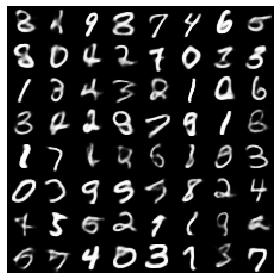

  7%|▋         | 72/1000 [38:35<8:17:44, 32.18s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
NAN appeared!


ValueError: 

In [10]:
print_info_ = 1
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)

best_elbo = -float("inf")
current_elbo_val = -float("inf")

current_tolerance = 0
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        target.decoder.train()
        plt.close()        

        mu, sigma,h = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        if ep < args.vanilla_vae_epoches:
            log_p = target.get_logdensity(z=z, x=batch_train)
            log_m = args.std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo_full = torch.mean(log_p - log_m)
            (-elbo_full).backward()
            optimizer_vanilla.step()
            optimizer_vanilla.zero_grad()
            if b_num == (args.train_batch_size - 1):
                args.train_batch_size = batch_size
                dataset = Dataset(args, device=args.device)
        else:
            target.train()
            p_old = args.std_normal.sample(z.shape)
            cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]

            sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
            sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
            p = p_old
            if args.learnable_reverse:
                all_directions = torch.tensor([], device=args.device)
            else:
                all_directions = None
            for k in range(args.K):
                # sample alpha - transition probabilities 
                if args.amortize:
#                     pdb.set_trace()
                    z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                        p_old=p, k=cond_vectors[k], target_distr=target, accept_func= accept_func, h=h)
                else:
                    z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                        p_old=p, k=cond_vectors[k], target_distr=target, accept_func= accept_func, h=h) # sample a_i -- directions
                if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                    print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                            dataset.train.shape[0] // args['train_batch_size'],
                                                                               k + 1,
                                                        (directions==0.).to(float).mean(),
                                                                        (directions==1.).to(float).mean()))
                    if args.amortize:
                        print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                        print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
                if args.learnable_reverse:
                    all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
                # Accumulate alphas
                sum_log_alpha = sum_log_alpha + current_log_alphas
                sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
            ##############################################
            if args.hoffman_idea:
                if args.learnable_reverse:
                    log_r = reverse_kernel(z_fin=z.detach(), h=h, a=all_directions)
                    log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian - sum_log_sigma + sum_log_alpha
                else:
                    log_r = -args.K * torch_log_2
                    log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian - sum_log_sigma  + sum_log_alpha
                log_p = target.get_logdensity(z=z, x=batch_train) + args.std_normal.log_prob(p.sum(1))
                elbo_full = log_p + log_r - log_m
#                 pdb.set_trace()
                ### Gradient of the first objective:
                target.eval()
                obj_1 = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
                (-obj_1).backward(retain_graph=True)
                optimizer_inference.step()
                optimizer_inference.zero_grad()
                optimizer.zero_grad() 
                
                ### Gradient of the second objective:
                target.train()
                log_p = target.get_logdensity(z=z.detach(), x=batch_train) + args.std_normal.log_prob(p.detach()).sum(1)
                elbo_full = log_p# - log_m
                obj_2 = torch.mean(elbo_full)
                (-obj_2).backward()
                optimizer.step()
                optimizer_inference.zero_grad()
                optimizer.zero_grad()
            ###########################################################
            else:
                elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
                (-grad_elbo).backward()
            if args.clip_norm:
                torch.nn.utils.clip_grad_norm_(itertools.chain(*params), args.clip_value)
                
            if args.separate_params: # if we separate params of inference part and generation part
                optimizer_inference.step() # we always perform step for inference part
                if (ep - args.vanilla_vae_epoches) % args.train_only_inference_period > args.train_only_inference_cutoff: # but sometimes for gen
                    optimizer.step()
                optimizer.zero_grad()
                optimizer_inference.zero_grad()
            else:
                optimizer.step()
                optimizer.zero_grad()
                
    ###### validation ######
    target.decoder.eval()
#             pdb.set_trace()
    current_elbo_val = validate_vae(args=args, encoder=encoder, target=target, transitions=transitions, dataset=dataset)
    if (current_elbo_val != current_elbo_val).sum():
        print('NAN appeared!')
        raise ValueError
    if current_elbo_val > best_elbo:
        current_tolerance = 0
        best_elbo = current_elbo_val
        if not os.path.exists('./models/{}/'.format(args.data)):
            os.makedirs('./models/{}/'.format(args.data))
        torch.save(encoder,
            './models/{}/best_encoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_learnaccept_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                                args.hoffman_idea, args.learnable_accept))
        torch.save(target.decoder,
            './models/{}/best_decoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_learnaccept_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                                    args.hoffman_idea, args.learnable_accept))
        torch.save(transitions,
            './models/{}/best_transitions_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_learnaccept_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                                    args.hoffman_idea, args.learnable_accept))
        if args.learnable_reverse:
            torch.save(reverse_kernel,
            './models/{}/best_reverse_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_learnaccept_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                                    args.hoffman_idea, args.learnable_accept))

    else:
        current_tolerance += 1
        if current_tolerance >= args.early_stopping_tolerance:
            print("Early stopping on epoch {} (effectively trained for {} epoches)".format(ep,
                                              ep - args.early_stopping_tolerance))
            break
                
    if ep % print_info_ == 0:
        target.decoder.eval()
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO train:', elbo_full.detach().mean().item())
        print('Best elbo validation', best_elbo)
        print('Current elbo validation', current_elbo_val)
        plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
print(best_elbo)

In [ ]:
elbo_full.mean()

In [ ]:
print(args.learnable_reverse)

## Vanilla VAE

In [14]:
dataset = Dataset(args, device=args.device)

In [15]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

params = [encoder.parameters(), target.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

In [16]:
print_info_ = 10

# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        
        mu_dec, sigma_dec = target.decoder(z)
        if args.data == 'toy_data':
            log_numenator = torch.distributions.Normal(loc=mu_dec, scale=sigma_dec).log_prob(batch_train).sum(1) + args.std_normal.log_prob(z).sum(1)
        else:
            log_numenator = torch.distributions.Bernoulli(logits=mu_dec).log_prob(batch_train).sum([1, 2, 3]) + args.std_normal.log_prob(z).sum(1)
        log_denumenator = -torch.sum(torch.log(sigma), 1) + args.std_normal.log_prob(u).sum(1)
        elbo = torch.mean(log_numenator - log_denumenator)
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    if ep % print_info_ == 0:
        if args.data == 'toy_data':
            print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo.detach().mean().item())
            print('Mean abs mu0:', torch.mean(torch.abs(mu_dec[:, 0])).cpu().detach().numpy())
            print('Mean sigma', torch.mean(sigma).cpu().detach().numpy())
            print('Max sigma', torch.max(sigma).cpu().detach().numpy())
            print('Min sigma', torch.min(sigma).cpu().detach().numpy())
            plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1], label='Data')
            plt.scatter(mu_dec.cpu().detach().numpy()[:, 0], mu_dec.cpu().detach().numpy()[:, 1], label='Reconstructed')
            plt.legend()
            plt.show()
        else:
            plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)


  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [ ]:
target.decoder.linear1.bias